<a href="https://colab.research.google.com/github/alnibl/Portfolio/blob/main/%D0%A1%D0%B1%D0%BE%D1%80%2C_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D0%B8_%D0%BF%D0%B0%D1%80%D1%81%D0%B8%D0%BD%D0%B3_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85_ipynb%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests # библиотека для отправки запросов в Интернет
from bs4 import BeautifulSoup # библиотека для обработки полученных данных
import os # библиотека для работы с файлами и папками
from tqdm import tqdm # библиотека для отображения прогресса в цикле
import urllib.request # библиотка для скачивания изображений
import pprint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Машины

## Сбор информации о доступных марках 
[Внешний вид сайта](https://drive.google.com/file/d/1uNienFd7N4TBnkOKcmrTNNhtL0q7-9Kb/view?usp=sharing)

http://www.motorpage.ru/media/photos.html

In [ ]:
link_root = 'http://www.motorpage.ru' # сайт, с которого будем получать изображения

r = requests.get(link_root + '/media/photos.html') # получение информации о галерее изображений
soup = BeautifulSoup(r.text) # создание объекта для обработки текста страницы

In [ ]:
r.text

In [ ]:
car_cards = soup.findAll('a', {'class': "col-xs-12 col-sm-6 zero-padding"}) # сбор информации о "карточках" всех марок

In [ ]:
car_cards

In [ ]:
brand_links = [card['href'] for card in car_cards] # получение окончания ссылки для каждого бренда
brand_names = [link[1:link.rfind('/')].capitalize() for link in brand_links] # получение имени каждого бренда

brand_dict = {k:v for k, v in zip(brand_names, brand_links)} # создаём словарь, в котором каждому названия бренда сопоставлена ссылка на страницу с фотографиями

In [ ]:
brand_links[0]

'/Acura/photos.html'

In [ ]:
brand_dict

In [ ]:
number_cards = soup.findAll('figcaption', {'class': "caption-photos"}) # получение карточки с числом для каждой карточки марки

In [ ]:
card_values = [int(card.text) for card in number_cards] # получение текста с каждой карточки и преобразование в число

brand_numbers = list(zip(brand_names, card_values)) # создание пар (имя бренда, количество фото)
brand_numbers.sort(key = lambda x: x[1], reverse = True) # сортировка пар по количеству фото в обратном порядке

In [ ]:
len(brand_numbers)

142

In [ ]:
#brands_to_consider = 3 # количество брендов, которые будут рассмотрены при решении задачи
#interesting_brands_info = brand_numbers[:brands_to_consider] # отбрасываем лишние бренды

In [ ]:
#interesting_brands_info

[('Mercedesbenz', 3101), ('Kia', 3085), ('Audi', 2767)]

In [ ]:
for brand_name, pic_num in brand_numbers: # итерация по списку с парами значений
    print(f'Для бренда {brand_name} присутствует {pic_num} изображений') # вывод информации о марках

In [ ]:
considered_brands = [brand_name for brand_name, pic_num in brand_numbers] # выбор названий только интересных нам брэндов

In [ ]:
considered_brands

In [ ]:
len(considered_brands)

142

## Сбор изображений по каждой марке

In [ ]:
data_path = '/content/drive/MyDrive/Базы/train_data/' # указание пути к данным
os.makedirs(data_path, exist_ok=True) # создание папки для данных, если её не существует

In [ ]:
c = sorted(os.listdir(data_path))
len(c)

141

In [ ]:
s = 0 
for i in sorted(os.listdir(data_path)):
  s = s + len(os.listdir(data_path + i + '/'))
print(s) 

26429


In [ ]:
link_dict = {} # словарь бренд:список ссылок на фото

for brand_name in considered_brands: # итерация по рассматриваемым брендам
    os.makedirs(data_path + brand_name, exist_ok=True) # создание папки бренда, если её не существует
    
    current_link = link_root + brand_dict[brand_name] # создание текущей ссылки с помощью ранее созданного словаря
    r = requests.get(current_link) # получение информации об изображениях модели
    soup = BeautifulSoup(r.text) # объект для обработки информации
    
    model_cards = soup.findAll('a', {'class': "col-xs-12 col-sm-4 col-md-3"}) # сбор информации о карточках моделей
    model_links = [model_card['href'] for model_card in model_cards] # получение ссылки для изображений каждой модели
    brand_links = [] # хранилище для ссылок на изображения машин данного бренда

    for model_link in tqdm(model_links): # итерация по всем ссылкам на изображения с моделями

        direct_link = link_root + model_link
        r = requests.get(direct_link) # получение информации о сайте с изображениями
        soup = BeautifulSoup(r.text) # объект для поиска ссылок на сами изображения
        picture_frames = soup.findAll('img', {'title': True}) # получение информации о "больших изображениях" на страницах моделей
        picture_links = [frame['src'] for frame in picture_frames] # сбор информации о ссылках на исходные изображения
        brand_links += picture_links # добавление ссылок для данной модели в общий пул ссылок по бренду

    link_dict[brand_name] = brand_links # сохранение информации о ссылках для данного бренда

In [ ]:
for brand_name, link_list in link_dict.items(): # разбираем словарь на название бренда и список ссылок на изображения
    dir_path = data_path + brand_name # текущая директория для сохранения изображений 
    for idx, link in enumerate(tqdm(link_list)): # итерируемся по списку ссылок, сохраняя номер итерации
        urllib.request.urlretrieve(link, f"{dir_path}/{idx}.jpg") # сохраняем изображения

#### Сохранение сгенерированных данных в zip archive 

In [ ]:
!zip -r "car_data.zip" '/content/drive/MyDrive/Базы'

#### Скачивание данных из Google Drive

In [ ]:
#!unzip '/content/drive/MyDrive/Занятия/Июльский курс/Доп семинары/car_parse.zip' -d './train_data/'

# ФОН ЛЕС

In [ ]:
from tensorflow.keras.preprocessing import image
from PIL import Image 

In [ ]:
data_path_drive = '/content/drive/MyDrive/Базы/Фон/' # указание пути к данным
#data_path_colab = './train_data/' # указание пути к данным
#os.makedirs(data_path_colab, exist_ok=True) # создание папки для данных, если её не существует
os.makedirs(data_path_drive, exist_ok=True) # создание папки для данных, если её не существует

In [ ]:
direct_link = 'https://oir.mobi/675981-doroga-v-lesu.html'
r = requests.get(direct_link) # получение информации о сайте с изображениями
soup = BeautifulSoup(r.text) # объект для поиска ссылок на сами изображения
picture_frames = soup.findAll('a', {'class': 'highslide'}) #
#picture_frames = soup.findAll('a')#, {'class': 'img-in-full'}) #
picture_links = [frame['href'] for frame in picture_frames] # сбор информации о ссылках на исходные изображения

In [ ]:
picture_frames

In [ ]:
len(picture_links)

49

In [ ]:
picture_links

['https://oir.mobi/uploads/posts/2021-05/1622285501_36-oir_mobi-p-doroga-v-lesu-priroda-krasivo-foto-43.jpg',
 'https://oir.mobi/uploads/posts/2021-05/1622285527_46-oir_mobi-p-doroga-v-lesu-priroda-krasivo-foto-54.jpg',
 'https://oir.mobi/uploads/posts/2021-05/1622285449_6-oir_mobi-p-doroga-v-lesu-priroda-krasivo-foto-6.jpg',
 'https://oir.mobi/uploads/posts/2021-05/1622285437_12-oir_mobi-p-doroga-v-lesu-priroda-krasivo-foto-12.jpg',
 'https://oir.mobi/uploads/posts/2021-05/1622285435_28-oir_mobi-p-doroga-v-lesu-priroda-krasivo-foto-33.jpg',
 'https://oir.mobi/uploads/posts/2021-05/1622285493_13-oir_mobi-p-doroga-v-lesu-priroda-krasivo-foto-13.jpg',
 'https://oir.mobi/uploads/posts/2021-05/1622285475_10-oir_mobi-p-doroga-v-lesu-priroda-krasivo-foto-10.jpg',
 'https://oir.mobi/uploads/posts/2021-05/1622285472_26-oir_mobi-p-doroga-v-lesu-priroda-krasivo-foto-31.jpg',
 'https://oir.mobi/uploads/posts/2021-05/1622285513_44-oir_mobi-p-doroga-v-lesu-priroda-krasivo-foto-51.jpg',
 'https://oi

In [ ]:
data_path_drive = '/content/drive/MyDrive/Базы/Фон/' # указание пути к данным
os.makedirs(data_path_drive, exist_ok=True) # создание папки для данных, если её не существует (для google drive нужно время)

In [ ]:
img_shape = (352,576,3) #размер изображения
img_width=img_shape[0]
img_height=img_shape[1]

In [ ]:
for idx, link in enumerate(tqdm(picture_links)): # итерируемся по списку ссылок, сохраняя номер итерации
    urllib.request.urlretrieve(link, f"{idx}.jpg") # сохраняем изображения в colab
    img = image.load_img(str(idx) + '.jpg', target_size=(img_width, img_height)) # загружаю изображение в переменную, меняю размер
    img.save(data_path_drive + str(idx) + '.jpg', 'JPEG') # сохраняю на гугл диск
    #!rm img.jpg # удаляю изображение из colab

100%|██████████| 49/49 [00:51<00:00,  1.05s/it]


In [ ]:
# ссылки на страницы сайта,где есть фото дорог
direct_link = ['https://oir.mobi/624377-dorozhka-v-parke.html', 
         'https://oir.mobi/624590-zimnjaja-doroga.html', 
         'https://oir.mobi/625317-doroga-osenju.html',
         'https://oir.mobi/624603-dorogi-v-novoj-zelandii.html',
         'https://oir.mobi/625328-shirokie-dorogi.html', 
         'https://oir.mobi/629289-doroga-v-zakat-51-foto.html',
         'https://oir.mobi/625337-dorogi-serpantiny.html',
         'https://oir.mobi/625484-doroga-mezhdu-letom-i-zimoj.html',
         'https://oir.mobi/624295-krasivaja-doroga.html',
         'https://oir.mobi/625771-doroga-v-more.html', 
         'https://oir.mobi/626050-art-dorogi.html', 
         'https://oir.mobi/627607-dorogi-v-pustynjah.html',
         'https://oir.mobi/627023-asfalt-na-zakate.html',
         'https://oir.mobi/626278-lesnye-tropinki.html', 
         'https://oir.mobi/628089-tropinki-v-trave.html',
         'https://oir.mobi/628353-razmytye-dorogi.html',
         'https://oir.mobi/628790-appieva-doroga.html',
         'https://oir.mobi/629034-osennie-tropy-47-foto.html',
         'https://oir.mobi/629044-doroga-v-parke-osenju-55-foto.html',
         'https://oir.mobi/630016-proselochnye-dorogi.html',
         'https://oir.mobi/628974-doroga-na-pole.html',
         'https://oir.mobi/631540-prjamye-dorogi.html',
         'https://oir.mobi/630689-zimnie-dorogi.html', 
         'https://oir.mobi/630694-doroga-v-tumane.html',
         'https://oir.mobi/656975-doroga.html',
         'https://oir.mobi/657405-trassa.html',
         'https://oir.mobi/675093-zimnjaja-doroga.html',
         'https://oir.mobi/674897-po-poljam.html',
         'https://oir.mobi/682904-krasivaja-doroga-v-lesu.html',
         'https://oir.mobi/677032-nochnaja-doroga-v-lesu.html',
         'https://oir.mobi/675981-doroga-v-lesu.html']

print('Количество ссылок на страницы с фото: {}'.format(len(direct_link)))

Количество ссылок на страницы с фото: 31


In [ ]:
link_dict = {} # словарь для сбора ссылок на все фото
background_links = [] # хранилище для ссылок на фото с одной страницы сайта
l = 0 # счетчик файлов

for i in tqdm(range(len(direct_link))):

  r = requests.get(direct_link[i]) # получение информации о странице сайта с изображениями
  soup = BeautifulSoup(r.text) # объект для поиска ссылок на сами изображения
  picture_frames = soup.findAll('a', {'class': 'highslide'}) #
  picture_links = [frame['href'] for frame in picture_frames] # сбор информации о ссылках на исходные изображения
  background_links += picture_links # добавление ссылок по каждой странице в общий список
  l += len(background_links) # для подсчета количества спаршеных фото
  link_dict[i] = background_links # словарь, где ключь это номер страницы сайта, а значение список ссылок на фото на этой странице
  background_links = [] # очищаю
print(' Всего ссылок на изображения: {}'.format(l)) # всего количество изображений

100%|██████████| 31/31 [00:19<00:00,  1.59it/s]

 Всего ссылок на изображения: 1482


In [ ]:
picture_links

[]

In [ ]:
len(link_dict), len(link_dict[0])

(31, 60)

In [ ]:
data_path_drive = '/content/drive/MyDrive/Базы/Фон/' # указание пути к данным
data_path_colab = '/content/Фон/' # указание пути к данным
os.makedirs(data_path_colab, exist_ok=True) # создание папки для данных, если её не существует
os.makedirs(data_path_drive, exist_ok=True) # создание папки для данных, если её не существует

In [ ]:
img_shape = (352,576,3) #размер изображения
img_width=img_shape[0]
img_height=img_shape[1]

In [ ]:
i = 0
for l, link_list in link_dict.items(): # разбираю словарь на ключ(номер страницы) и значение(ссылки на фото)
  os.makedirs(data_path_colab, exist_ok=True) # создание временной папки для данных, если её не существует
  for idx, link in enumerate(tqdm(link_list)): # итерируемся по списку ссылок, сохраняя номер итерации
        try:
          urllib.request.urlretrieve(link, f"{data_path_colab}{idx}.jpg") # сохраняем изображения в colab
          img = image.load_img(data_path_colab + str(idx) + '.jpg', target_size=(img_width, img_height)) # загружаю изображение в переменную, меняю размер
          img.save(data_path_drive + str(i) + '.jpg', 'JPEG') # сохраняю на google drive
          i += 1 
        except:
          print('Была ошибка')
  !rm -rf '/content/Фон/' # удаляю папку с файлами, чтобы не занимать память colab

 83%|████████▎ | 40/48 [00:45<00:08,  1.02s/it]

Была ошибка


100%|██████████| 49/49 [00:52<00:00,  1.06s/it]


# Получаю картинки авто на прозрачном фоне. Сохраняю на google drive

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F

from tensorflow.keras.preprocessing import image
from PIL import Image 

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt   # Отрисовка изображений в Colab
import math
import numpy as np
import sys
import os
import time
from tqdm import tqdm # библиотека для отображения прогресса в цикле

#Базовые слои для счёрточных сетей
from tensorflow.keras.preprocessing.image import ImageDataGenerator # работа с изображениями
from google.colab import files #Для загрузки своей картинки

import random #Для генерации случайных чисел 


# подключем диск
from google.colab import drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Беру машины из занятия по сверткам

In [ ]:
#os.makedirs('/content/drive/MyDrive/Базы/Обрезанные/Renault/', exist_ok=True) # создание папки для данных, если её не существует
#!unzip '/content/drive/MyDrive/Базы/1.zip' -d '/content/drive/MyDrive/Базы/'

In [ ]:
# распаковываю в colab архив машин с занятия
#!unzip -q "/content/drive/MyDrive/Базы/middle_fmr.zip" -d /content/cars #Указываем путь к базе в Google Drive

In [ ]:
#car = {'Kia': '/content/drive/MyDrive/Базы/train_data/Kia/'}

In [ ]:
car = {'Mercedesbenz': '/content/drive/MyDrive/Базы/train_data/Mercedesbenz/'}

In [ ]:
'''
car = {'Volvo': '/content/drive/MyDrive/Базы/train_data/Volvo/',
       'Kia': '/content/drive/MyDrive/Базы/train_data/Kia/',
       'Mercedesbenz': '/content/drive/MyDrive/Базы/train_data/Mercedesbenz/', 
       'Ford': '/content/drive/MyDrive/Базы/train_data/Ford/',
       'Opel': '/content/drive/MyDrive/Базы/train_data/Opel/',
       }
'''

In [ ]:
'''
# сегментирую все авто Mercedes и Ferrari
path_img = '/content/cars/Mercedes/' #Папка с папками картинок
path_img_len = os.listdir(path_img)  # Лист с именами всех фото в папке

#save_path = '/content/drive/MyDrive/Базы/Сегментированные/'

path_pruning = '/content/drive/MyDrive/Базы/Обрезанные/Mercedes/' # Путь где сохранять обрезанные
os.makedirs('/content/drive/MyDrive/Базы/Обрезанные/Mercedes/', exist_ok=True) # создание папки для данных, если её не существует
path_pruning_len = os.listdir(path_pruning) # Имена всех фото в папке

'''

In [ ]:
# загружаю модель
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True, progress=True, num_classes=21, aux_loss=None).eval()

# Задаю набор трансформаций
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.485, 0.456, 0.406), 
                                                                            std=(0.229, 0.224, 0.225))])

## Функция получения сегментированного изображения, используя предобученную сеть

In [ ]:
# функция принимает предобученную модель, изображение, и набор нужных трансформаций для правильной работы модели
def torch_model_segmentation(model, transform, img_real):
  
  img = np.array(img_real)
  img = transform(img)  # применяю трансформацию
  img = img.unsqueeze(0)  # добавляю одно измерение
  output = model(img)['out'] # пропускаю через предобученную модель
  normalized_masks = torch.nn.functional.softmax(output, dim=1) # применяю softmax
  normalized_masks = normalized_masks.argmax(1) # argmax - классифицирует каждый пиксель
  img_seg = normalized_masks[0]
  img_seg = np.array(img_seg)
  img_seg = Image.fromarray(img_seg.astype('uint8')).convert('RGBA') # перевожу сегментированную карту в RGBA

  return img_seg


## Функция переноса цвета пикселей на сегментированного авто + прозрачный фон.


In [ ]:
# Переношу занчение пикселей в RGBA с реального зображения на сегментированное, оставляя прозрачным фон
def segmentation_color_real(img_real, img_seg):
  
  img_real = img_real.convert('RGBA')
  img_real = np.array(img_real)
  out = img_real.copy()

  img_seg = img_seg.convert('L') # Перевожу изображение в черно-белое, одноканальное
  img_seg = np.array(img_seg)

  # прохожусь по всем строкам и всем колонкам
  for st in range(img_seg.shape[0]):
                for col in range(img_seg.shape[1]):
                  if img_seg[st, col] == 7:
                    r, g, b, a = img_real[st, col]        # записываю значение rgba нужных пикселей c оригинального изображения
                    out[st, col] = [r, g, b, a]      # переношу значение rgba в изображение
                  elif img_seg[st, col] != 7:     # все пиксели кроме кота
                    out[st, col] = [0, 0, 0, 0]   # цвет фона в rgba (черный с нулевым уровнем яркости = прозрачный)
  
  out_super = out.astype('uint8')
  out_super = Image.fromarray(out_super).convert('RGBA')
  
  return out_super     


## Общая функция, которая сегментирует, разукрашивает авто, делает фон прозрачным

In [ ]:
# Общая функция, которая сегментирует, разукрашивает авто, делает фон прозрачным
def coloring_pruning(model, transform, img_real):

  img_seg = torch_model_segmentation(model, transform, img_real)
  out_super = segmentation_color_real(img_real, img_seg)
 
  return out_super

In [ ]:
for k, w in car.items(): # разбираю словарь на ключ k(название марки авто) значение w (путь к этой папке с фотограффиями машин)

  path_img = w #Путь к папке c фото машин
  path_img_len = os.listdir(w)  # Лист с именами всех фото в папке

  path_pruning ='/content/drive/MyDrive/Базы/Обрезанные/'  + k + '/'# Путь где сохранять обрезанные
  os.makedirs(path_pruning, exist_ok=True) # создание папки для данных, если её не существует
  time.sleep(10) # задержка 10 сек, для того, чтобы создалась папка на google drive
  #path_pruning_len = os.listdir(path_pruning) # Лист с именами всех фото в папке

  for idx, filename in enumerate(tqdm(sorted(path_img_len))): # прохожусь по названию каждого файла в папке
    img_real = Image.open(path_img + filename) # открываю файл
    out_super = coloring_pruning(model, transform, img_real) # функция, которая сегментирует авто, разукрашивает его в реальный цвет и делает прозрачным фон
    out_super.save(path_pruning + str(idx) + '.png', 'PNG') # сохраняю

100%|██████████| 649/649 [4:11:45<00:00, 23.28s/it]


#Собираю фото лесных дорог из видео

Пробую сегментиовать авто имено из видео, из которого буду удалять машину при помощи НС

Сегментирую все авто с 1 мин. 20 сек, до 2 мин 50 сек.
url = 'lB0bkZVlQd4'

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm_notebook
from tensorflow.keras.models import load_model
import colorsys 

from tensorflow.keras.preprocessing import image
from PIL import Image 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Загрузка видео с ютуба
# https://github.com/ytdl-org/youtube-dl/

!pip install youtube_dl   

     |████████████████████████████████| 1.9 MB 5.2 MB/s 


In [ ]:
import youtube_dl
from IPython.display import YouTubeVideo
from moviepy.editor import *

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1769472/45929032 bytes (3.9%)4415488/45929032 bytes (9.6%)7569408/45929032 bytes (16.5%)10682368/45929032 bytes (23.3%)13770752/45929032 bytes (30.0%)16621568/45929032 bytes (36.2%)19136512/45929032 bytes (41.7%)22028288/45929032 bytes (48.0%)24829952/45929032 bytes (54.1%)27721728/45929032 bytes (60.4%)30580736/45929032 bytes (66.6%)33284096/45929032 bytes (72.5%)3

In [ ]:
https://www.youtube.com/watch?v=nXCJIGP2gvo
#https://www.youtube.com/watch?v=fztDYdbjLDk
#https://www.youtube.com/watch?v=PnTx_nrpf1w
#https://www.youtube.com/watch?v=iBbPtJI7Sto
#https://www.youtube.com/watch?v=tDxWmgaTM9w
#https://www.youtube.com/watch?v=kDOqsAvNeHs
#https://www.youtube.com/watch?v=Zgc5YNEZug8
#https://www.youtube.com/watch?v=9tohEPv5UFE
#https://www.youtube.com/watch?v=6JGPKw2XVpU
#https://www.youtube.com/watch?v=JHAcW9cU0mY
#https://www.youtube.com/watch?v=dpu1tij-9_k
#https://www.youtube.com/watch?v=TWPTjeGfn0k
url = 'QMtezVZWtb8'
url ='kmpHl6NRjmE'

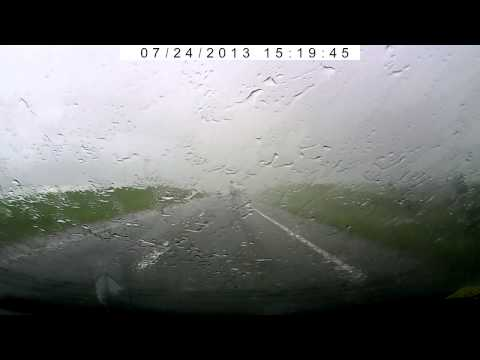

In [ ]:
url ='nXCJIGP2gvo'
YouTubeVideo(url, start=0)

In [ ]:
!rm test.mp4

# Загружаем видео с youtube
!youtube-dl -f mp4 --output "test.%(ext)s" 'https://www.youtube.com/watch?v={url}'

rm: cannot remove 'test.mp4': No such file or directory
[youtube] nXCJIGP2gvo: Downloading webpage
[youtube] nXCJIGP2gvo: Downloading player ea6a4ba6
[youtube] nXCJIGP2gvo: Downloading MPD manifest
[download] Destination: test.mp4
[download] 100% of 32.89MiB in 09:43


In [ ]:
# -i          Что?
# -c copy     Куда?
# -ss         Начиная с какой секунды?
# -t          Какой интервал взять?

!ffmpeg -i '/content/test.mp4' -ss 00:00:00.00 -t 00:01:59.00 -c copy out.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [ ]:
video_ = '/content/out.mp4'

  0%|          | 0/10 [00:00<?, ?it/s]

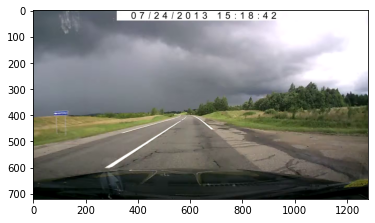

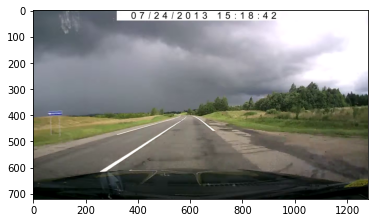

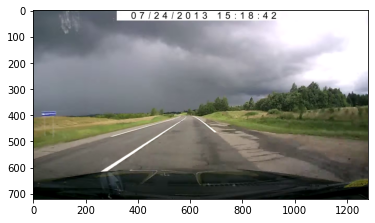

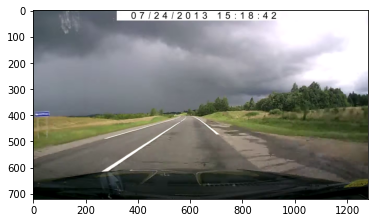

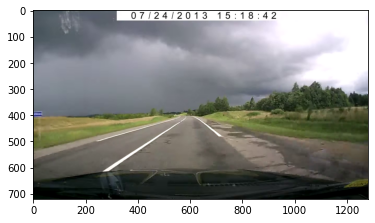

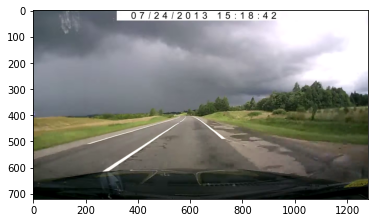

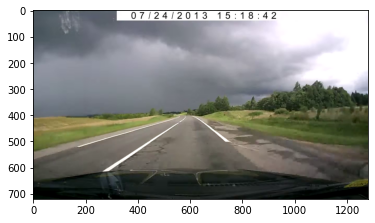

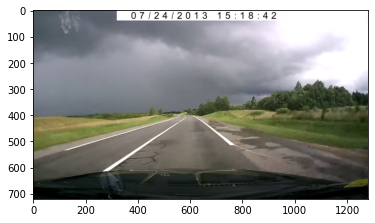

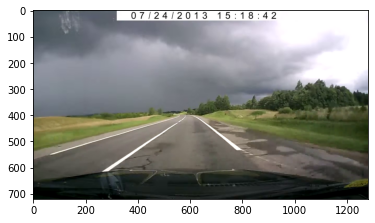

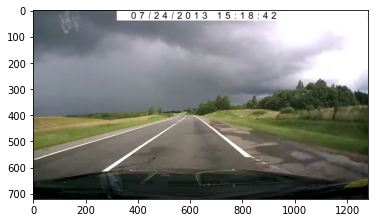

In [ ]:
video_reader = cv2.VideoCapture(video_)

nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
frame_h   = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_w   = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
fps       = int(video_reader.get(cv2.CAP_PROP_FPS))

for i in tqdm_notebook(range(10)): 
    _, img = video_reader.read()
    plt.imshow(img[:,:, ::-1]) # меняю BGR на RGB
    plt.show()

In [ ]:
# Создаем класс для чтения видео
video_reader = cv2.VideoCapture(video_)

nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
frame_h   = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_w   = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
fps       = int(video_reader.get(cv2.CAP_PROP_FPS))

images = []

for i in tqdm_notebook(range(fps*56)): # Берем ... секунды видео

    # Обрабатываем каждый фрейм видео    
    _, img = video_reader.read()
    if i % 100 == 0:                     # каждые ... сек
      img = img[:,:, ::-1]               # Конвертирую BGR -> RGB
      img = img.astype('uint8')          # меняю тип
      img = Image.fromarray(img )        # делаю изображением
      img = img.resize((576,352))        # меняю размер

      images.append(img)                 # добавляю фото в массив

  0%|          | 0/1680 [00:00<?, ?it/s]

In [ ]:
len(images)

17

Сохраняю сегментированные машины из видео ютуб

In [ ]:
path_pruning ='/content/drive/MyDrive/Базы/Обрезанные/Youtube/'# Путь где сохранять файлы

In [ ]:
for idx, img_real in enumerate(images): # прохожусь по каждому файлу
  #img_real = Image.open(path_img + filename) # открываю файл
  out_super = coloring_pruning(model, transform, img_real) # функция, которая сегментирует авто, разукрашивает его в реальный цвет и делает прозрачным фон
  out_super.save(path_pruning + str(idx) + '.png', 'PNG') # сохраняю

Сохоаняю фоны с видео ютуб

In [ ]:
#path_pruning ='/content/drive/MyDrive/Базы/Фон/Youtube/'# Путь где сохранять файлы

In [ ]:
path_pruning ='/content/drive/MyDrive/Базы/1/'# Путь где сохранять файлы

In [ ]:
len(images)

17

In [ ]:
for idx, img in tqdm_notebook(enumerate(images)): # прохожусь по каждому файлу

  #img_real = Image.open(path_img + filename) # открываю файл
  #out_super = coloring_pruning(model, transform, img_real) # функция, которая сегментирует авто, разукрашивает его в реальный цвет и делает прозрачным фон
  img.save(path_pruning + '11_'+ str(idx) + '.jpg', 'JPEG') # сохраняю

0it [00:00, ?it/s]